In [1]:
''' RNN Bidireccional en Keras '''

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates

Using TensorFlow backend.


In [8]:
# Radon
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
dates[-1]

Timestamp('2019-07-21 00:00:00', freq='W-SUN')

In [9]:
# Weather
BCN = pd.read_csv('../Data/Daily/BCN/BCN_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
BCN['fecha'] = pd.to_datetime(BCN['fecha'])
BCN.describe()

,tmed,velmedia,presmed
count,316.000000,316.000000,316.000000
mean,17.587430,4.503505,1016.763222
std,5.790832,0.691445,5.295843
min,6.542857,2.414286,1000.528571
25%,12.575000,4.071429,1013.675000
50%,17.007143,4.442857,1016.432143
75%,22.834364,4.885714,1019.176786
max,29.900000,8.200000,1031.835714


In [12]:
sample_size = 4
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': BCN['tmed'].values})

In [13]:
def scaler(DF, field):
    scaled = MinMaxScaler().fit(DF[[field[0], field[1]]].values).transform(DF[[field[0], field[1]]].values)
    output = pd.DataFrame(scaled, columns=['T', 'mdnRnA'])
    output['dates'] = DF['dates']
    return output
DF_scaled = scaler(DF, ['T', 'mdnRnA'])
DF_scaled.head()

,T,mdnRnA,dates
0,0.824465,0.573333,2013-07-07
1,0.817737,0.426667,2013-07-14
2,0.834251,0.693333,2013-07-21
3,0.885015,0.933333,2013-07-28
4,0.823853,0.693333,2013-08-04


In [19]:
DF_to3d = DF_scaled[['T']].values
X = np.array([DF_to3d[start:start+sample_size] for start in range(0, DF_to3d.shape[0]-sample_size)])
Y = mdnRnA[sample_size:]

In [22]:
# Training set first 5 years, Test set last year
test_size = int(0.3*len(mdnRnA))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]

In [23]:
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (218, 4, 1) 
Y_train.shape =  (218,)


In [62]:
def NN(neurons, nep, v=0, btch_size=10):
    model = Sequential()
    model.add(Conv1D(filters=neurons[0], kernel_size=3, activation='relu', input_shape=(sample_size, 1)))
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Flatten())
    model.add(Dense(neurons[0], activation='relu'))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    print(model.summary())
    return history, pred, acc_train, acc_test

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2, 64)             256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________
None
ECM

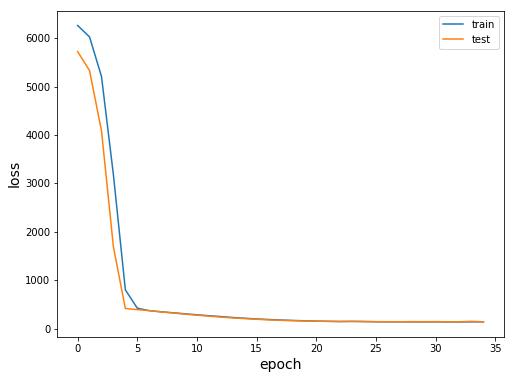

In [63]:
neuron = [64, 32]
history, pred, acc_train, acc_test = NN(neuron, nep=35)
# Errors
testScoreECM = mean_squared_error(Y_test, pred)
print('ECM: ', testScoreECM)
testScoreEAM = mean_absolute_error(Y_test, pred)
print('EAM: ', testScoreEAM)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#ax.set_yscale("log")
#plt.title('model loss')
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'test'], loc='upper right')

In [64]:
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D')

Text(0.5,0.98,'Weekly Fitting at LSC - Hall A')

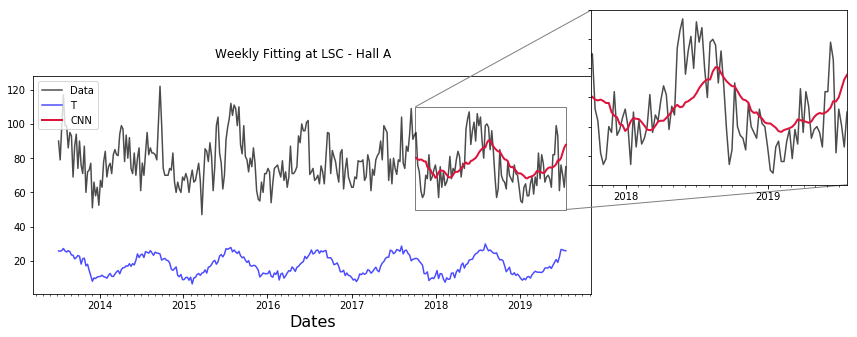

In [65]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))
plt.figure(1)
xaxis = ax.get_xaxis()
#ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, 'k', alpha=0.7) 
ax.plot(DF['dates'].values, DF['T'].values, 'b', alpha=0.7) 
ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
plt.xlabel('Dates', fontsize=16)
ax.legend(['Data', 'T','CNN'], loc='upper left')
#plt.ylim([30, 140])

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
axins = zoomed_inset_axes(ax, 1.7, loc='lower left', bbox_to_anchor=(643,140))
axins.xaxis.set_major_locator(mdates.YearLocator())
axins.xaxis.set_minor_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axins.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, 'k', alpha=0.7)
axins.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), DF['T'].values, 'b', alpha=0.7) 
axins.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
axins.set_xlim('2017-10-05', '2019-07-21')
axins.set_ylim(50, 110)

plt.xticks(visible=True)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.suptitle('Weekly Fitting at LSC - Hall A')